Week 6 · Day 4 — Hyperparameter Tuning
Why this matters

Hyperparameters (LR, batch size, hidden width, dropout, optimizer choice…) control whether a net trains well or fails.
Systematic tuning saves time and leads to much stronger models.

Theory Essentials

Hyperparameters (set before training): learning rate, hidden sizes, depth, batch size, dropout, optimizer, weight decay.

Search strategies:

Grid search: try all combos (expensive).

Random search: sample combos (often better).

Learning rate finder: plot loss vs LR to pick a good range.

Best practice:

Start small (1–3 epochs).

Track validation accuracy.

Use logs/plots to compare.

In [3]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=1000)

# ---------- Model ----------
class MLP(nn.Module):
    def __init__(self, hidden_size=128, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

# ---------- Train/Eval ----------
def train_eval(hidden_size, lr, dropout, epochs=3):
    model = MLP(hidden_size, dropout)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    # Train
    for epoch in range(epochs):
        model.train()
        for X,y in train_loader:
            opt.zero_grad()
            loss = crit(model(X),y)
            loss.backward()
            opt.step()
        print("Epoch:", epoch)
    # Validation
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for X,y in val_loader:
            preds = model(X).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total

# ---------- Hyperparam sweep ----------
configs = [
    {"hidden":64,  "lr":0.001, "drop":0.0},
    {"hidden":128, "lr":0.001, "drop":0.3},
    {"hidden":256, "lr":0.0005,"drop":0.5},
]

for cfg in configs:
    acc = train_eval(cfg["hidden"], cfg["lr"], cfg["drop"])
    print(cfg, "→ Val acc:", round(acc,3))


Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 64, 'lr': 0.001, 'drop': 0.0} → Val acc: 0.942
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 128, 'lr': 0.001, 'drop': 0.3} → Val acc: 0.952
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 256, 'lr': 0.0005, 'drop': 0.5} → Val acc: 0.944


1) Core (10–15 min)
Task: Run the sweep above. Which config gives best validation accuracy?

The config using {"hidden":128, "lr":0.001, "drop":0.3} gives the best validation accuracy

2) Practice (10–15 min)
Task: Add a config with learning rate 0.01. Does it diverge or train faster?

In [2]:
configs = [
    {"hidden":64,  "lr":0.001, "drop":0.0},
    {"hidden":128, "lr":0.001, "drop":0.3},
    {"hidden":256, "lr":0.0005,"drop":0.5},
    {"hidden":128, "lr":0.01, "drop":0.3},
]

for cfg in configs:
    acc = train_eval(cfg["hidden"], cfg["lr"], cfg["drop"])
    print(cfg, "→ Val acc:", round(acc,3))

{'hidden': 64, 'lr': 0.001, 'drop': 0.0} → Val acc: 0.944
{'hidden': 128, 'lr': 0.001, 'drop': 0.3} → Val acc: 0.952
{'hidden': 256, 'lr': 0.0005, 'drop': 0.5} → Val acc: 0.944
{'hidden': 128, 'lr': 0.01, 'drop': 0.3} → Val acc: 0.96


It is slightly faester and diverges less as it has better accuracy

3) Stretch (optional, 10–15 min)
Task: Write a loop that samples random hyperparameters (hidden size in [64,512], dropout in [0,0.5], lr in [1e-4,1e-2]) and tests 5 configs.

In [4]:
import random

configs = []
for _ in range(5):
    cfg = {
        "hidden": random.choice([64, 128, 256, 512]),         # hidden size
        "lr": random.choice([1e-4, 1e-3, 1e-2]),              # learning rate
        "drop": round(random.uniform(0.0, 0.5), 2)            # dropout between 0.0 and 0.5
    }
    configs.append(cfg)

print(configs)

for cfg in configs:
    acc = train_eval(cfg["hidden"], cfg["lr"], cfg["drop"])
    print(cfg, "→ Val acc:", round(acc, 3))


[{'hidden': 256, 'lr': 0.001, 'drop': 0.4}, {'hidden': 128, 'lr': 0.01, 'drop': 0.4}, {'hidden': 256, 'lr': 0.01, 'drop': 0.32}, {'hidden': 512, 'lr': 0.0001, 'drop': 0.35}, {'hidden': 128, 'lr': 0.0001, 'drop': 0.47}]
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 256, 'lr': 0.001, 'drop': 0.4} → Val acc: 0.959
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 128, 'lr': 0.01, 'drop': 0.4} → Val acc: 0.957
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 256, 'lr': 0.01, 'drop': 0.32} → Val acc: 0.965
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 512, 'lr': 0.0001, 'drop': 0.35} → Val acc: 0.916
Epoch: 0
Epoch: 1
Epoch: 2
{'hidden': 128, 'lr': 0.0001, 'drop': 0.47} → Val acc: 0.893


Mini-Challenge (≤40 min)

Task: Implement a learning rate finder:

Train one model, start LR at 1e-5, multiply by 1.2 each batch.

Plot loss vs LR.

Identify LR range where loss decreases smoothly.

Acceptance Criteria:

Plot LR vs loss.

Mark “good LR zone”.

Brief note: why is this better than guessing LR?

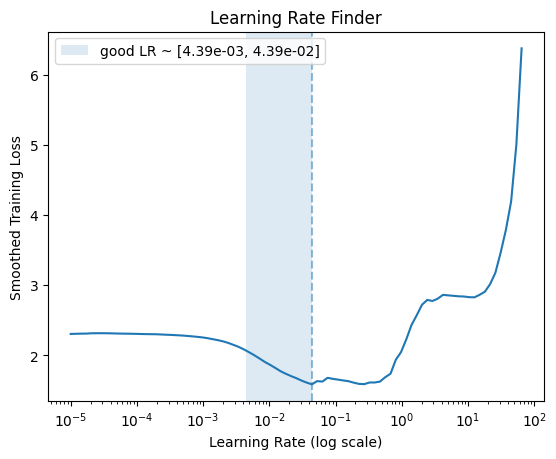

Suggested LR range: [4.39e-03, 4.39e-02]  (pick ~ 1.46e-02 to 4.39e-02)


In [5]:
# --- Learning Rate Finder (Leslie Smith style) ---
import math

def lr_finder(lr_start=1e-5, lr_mult=1.2, max_batches=200, smooth_beta=0.98):
    # fresh model each time
    model = MLP(hidden_size=128, dropout=0.0)
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr_start)

    lrs, losses, smoothed, avg_loss = [], [], [], 0.0
    lr = lr_start
    best_loss = float('inf')

    model.train()
    batches_done = 0
    for X, y in train_loader:
        # forward/backward/step
        opt.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        opt.step()

        # smoothing for a clean curve
        batches_done += 1
        avg_loss = smooth_beta*avg_loss + (1-smooth_beta)*loss.item()
        corr_loss = avg_loss / (1 - smooth_beta**batches_done)

        lrs.append(lr)
        losses.append(loss.item())
        smoothed.append(corr_loss)

        # track best & early stop if it explodes
        best_loss = min(best_loss, corr_loss)
        if math.isnan(corr_loss) or corr_loss > 4*best_loss:
            break

        # increase LR for the next batch
        lr *= lr_mult
        for g in opt.param_groups:
            g['lr'] = lr

        if batches_done >= max_batches:
            break

    # pick a suggested range: [best/10, best]
    idx_min = int(torch.tensor(smoothed).argmin().item())
    lr_best = lrs[idx_min]
    lr_low  = lr_best / 10
    return lrs, smoothed, (lr_low, lr_best)

# ----- Run LR finder -----
lrs, smoothed_losses, (lr_low, lr_best) = lr_finder(lr_start=1e-5, lr_mult=1.2, max_batches=250)

# ----- Plot LR vs Loss (+ good LR zone) -----
plt.figure()
plt.plot(lrs, smoothed_losses)
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Smoothed Training Loss")
plt.title("Learning Rate Finder")

# mark good LR zone [best/10, best]
plt.axvspan(lr_low, lr_best, alpha=0.15, label=f"good LR ~ [{lr_low:.2e}, {lr_best:.2e}]")
plt.axvline(lr_best, ls="--", alpha=0.5)
plt.legend()
plt.show()

print(f"Suggested LR range: [{lr_low:.2e}, {lr_best:.2e}]  (pick ~ {lr_best/3:.2e} to {lr_best:.2e})")




## What the code does (in plain English)

* **Make a fresh model** (so weights are untouched).
* **Start LR very small** (`1e-5`) and **increase it every batch** by ×1.2.
* For each batch:

  * Do a normal train step (forward → loss → backward → optimizer step).
  * **Record the loss** and a **smoothed loss** (exponential moving average) so the curve isn’t noisy.
  * **Early-stop** if loss explodes (bigger than 4× the best so far).
  * Set the **next LR** = current LR × 1.2.
* **Plot loss vs LR on a log scale** to see behavior over many orders of magnitude.
* **Mark the “good LR zone”** as `[LR_min/10, LR_min]`, where `LR_min` is the LR at the lowest smoothed loss.

## How to read your plot

From left to right (LR increasing):

1. **Flat/high loss at tiny LRs (\~1e-5 → 1e-3)**
   Steps are too small → very slow learning.
2. **Smooth, steady **decrease** (the sweet spot)**
   This is where larger LRs make faster progress without instability.
3. **Bottom of the curve (minimum loss)**
   The best LR *during this sweep* — often a bit too high to train at; we back off.
4. **Loss turns up / spikes**
   LR is now too high → updates overshoot → divergence.

## What your numbers mean

* Shaded region: **good LR ≈ `[4.39e-03, 4.39e-02]`**
* Dashed line: the **minimum** point (`~4.39e-02`).
* **Pick an LR near the lower/middle of the band** for training, e.g. **`1e-2` to `2e-2`**.
  (Rule of thumb: \~`LR_min/3` is a safe pick.)

## Why this is better than guessing

It’s a **quick, empirical sweep** that shows where loss improves smoothly and where it blows up. You avoid:

* LRs that are **too small** (waste time),
* LRs that are **too big** (fail to train).




Notes / Key Takeaways

Hyperparameters can make/break training.

Random search often outperforms grid (try more diverse values).

Learning rate is the single most important hyperparameter.

Use validation accuracy as the selection metric.

Automating sweeps = saves massive time.

1. Why is random search often better than grid search in deep nets?

Grid search wastes time: many hyperparameters don’t matter much, but grid still tests all combinations.

Random search explores more diverse values, so it’s more likely to stumble on good configs faster.

Especially in deep nets, only a few hyperparameters (like learning rate, dropout) have big impact → random search finds them more efficiently.

2. Why is LR the most critical hyperparameter to tune first?

LR controls the size of each weight update.

Too small → painfully slow learning; too big → divergence/instability.

Getting LR right unlocks good training dynamics; most other hyperparameters (batch size, hidden units, etc.) matter less if LR is badly chosen.